In [72]:
import numpy as np 
import pandas as pd 

import random as rn

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

import chart_studio.plotly as py
import plotly.graph_objs as go
from plotly import tools
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold 
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.pipeline import Pipeline
from scipy.stats import uniform

import itertools

import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)


import os
print(os.listdir("./input"))

['test.csv', 'mnist_train.csv', 'train.csv', 'sample_submission.csv', 'mnist_test.csv']


In [73]:
img_rows, img_cols = 28, 28

np.random.seed(5)

In [74]:
def get_best_score(model):
    
    print(model.best_score_)    
    print(model.best_params_)
    print(model.best_estimator_)
    
    return model.best_score_

In [75]:
def print_validation_report(y_true, y_pred):
    print("Informe de clasificación")
    print(classification_report(y_true, y_pred))
    acc_sc = accuracy_score(y_true, y_pred)
    print("Exactitud : "+ str(acc_sc))
    
    return acc_sc

In [76]:
def plot_confusion_matrix(y_true, y_pred):
    mtx = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(8,8))
    sns.heatmap(mtx, annot=True, fmt='d', linewidths=.5,  cbar=False, ax=ax)
    #  square=True,
    plt.ylabel('Etiqueta real')
    plt.xlabel('Etiqueta predicha')

In [77]:
def plot_history_loss_and_acc(history_keras_nn):

    fig, axs = plt.subplots(1,2, figsize=(12,4))

    axs[0].plot(history_keras_nn.history['loss'])
    axs[0].plot(history_keras_nn.history['val_loss'])
    axs[0].set_title('pérdida de modelo')
    axs[0].set_ylabel('pérdida')
    axs[0].set_xlabel('epoch')
    axs[0].legend(['entrenamiento', 'validación'], loc='upper left')

    axs[1].plot(history_keras_nn.history['acc'])
    axs[1].plot(history_keras_nn.history['val_acc'])
    axs[1].set_title('precision del modelo')
    axs[1].set_ylabel('precision')
    axs[1].set_xlabel('epoch')
    axs[1].legend(['entrenamiento', 'validación'], loc='upper left')

    plt.show()

In [78]:
train = pd.read_csv("./input/train.csv")
test = pd.read_csv("./input/test.csv")

In [79]:
y = train["label"]
X = train.drop(["label"],axis = 1)
X_test = test

In [80]:
X = X/255.0
X_test = X_test/255.0

In [81]:
mode = "edit"
mode = "commit"

if mode == "edit" :
    nr_samples = 1200

if mode == "commit" :    
    nr_samples = 30000

y_train=y[:nr_samples]
X_train=X[:nr_samples]
start_ix_val = nr_samples 
end_ix_val = nr_samples + int(nr_samples/3)
y_val=y[start_ix_val:end_ix_val]
X_val=X[start_ix_val:end_ix_val]
    
print("nr_samples datos de entrenamiento:", nr_samples)
print("start_ix_val:", start_ix_val)
print("end_ix_val:", end_ix_val)

nr_samples datos de entrenamiento: 30000
start_ix_val: 30000
end_ix_val: 40000


In [82]:
print("X:")
print(X.info())
print("*"*50)
print("X_test:")
print(X_test.info())
print("*"*50)
print("y:")
print(y.shape)

X:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 784 entries, pixel0 to pixel783
dtypes: float64(784)
memory usage: 251.2 MB
None
**************************************************
X_test:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28000 entries, 0 to 27999
Columns: 784 entries, pixel0 to pixel783
dtypes: float64(784)
memory usage: 167.5 MB
None
**************************************************
y:
(42000,)


In [83]:
X.iloc[0:5,:]

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [84]:
y.iloc[0:5]

0    1
1    0
2    1
3    4
4    0
Name: label, dtype: int64

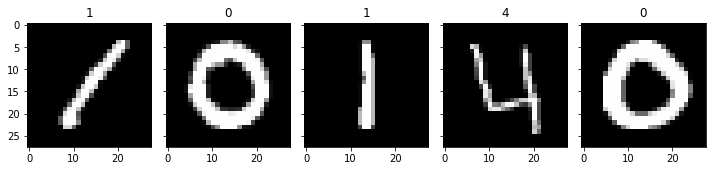

In [85]:
fig, axs = plt.subplots(1, 5, sharex=True, sharey=True, figsize=(10,6))
axs = axs.flatten()
for i in range(0,5):
    im = X.iloc[i]
    im = im.values.reshape(-1,28,28,1)
    axs[i].imshow(im[0,:,:,0], cmap=plt.get_cmap('gray'))
    axs[i].set_title(y[i])
plt.tight_layout()    

In [86]:
y.value_counts()

1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

/Users/vaps/opt/anaconda3/envs/ia/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



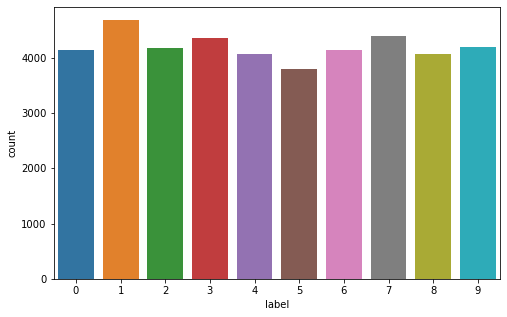

In [87]:
fig, ax = plt.subplots(figsize=(8,5))
g = sns.countplot(y)

In [88]:
li_idxs = []
for i in range(10):
    for nr in range(10):
        ix = y[y==nr].index[i]
        li_idxs.append(ix) 

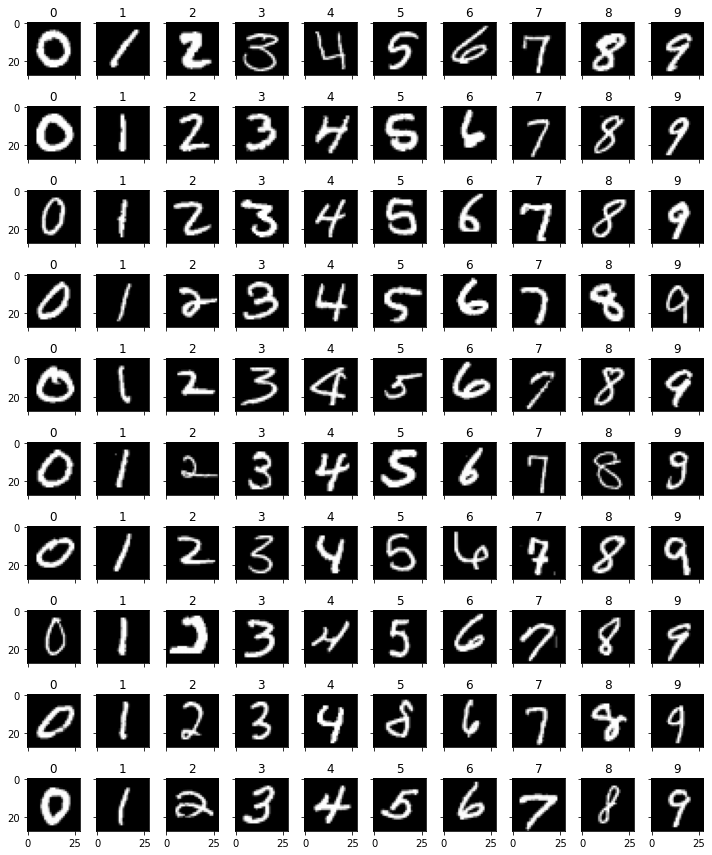

In [89]:
fig, axs = plt.subplots(10, 10, sharex=True, sharey=True, figsize=(10,12))
axs = axs.flatten()
for n, i in enumerate(li_idxs):
    im = X.iloc[i]
    im = im.values.reshape(-1,28,28,1)
    axs[n].imshow(im[0,:,:,0], cmap=plt.get_cmap('gray'))
    axs[n].set_title(y[i])
plt.tight_layout() 

In [90]:
from sklearn.linear_model import Perceptron
clf_Perceptron = Perceptron(random_state=0)
param_grid = { 'penalty': ['l1','l2'], 'tol': [0.05, 0.1] }
GridCV_Perceptron = GridSearchCV(clf_Perceptron, param_grid, verbose=1, cv=5)
GridCV_Perceptron.fit(X_train,y_train)
score_grid_Perceptron = get_best_score(GridCV_Perceptron)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
0.8595
{'penalty': 'l1', 'tol': 0.05}
Perceptron(penalty='l1', tol=0.05)


In [91]:
pred_val_perc = GridCV_Perceptron.predict(X_val)

In [92]:
acc_perc = print_validation_report(y_val, pred_val_perc)

Informe de clasificación
              precision    recall  f1-score   support

           0       0.95      0.96      0.96       998
           1       0.91      0.95      0.93      1127
           2       0.91      0.86      0.88       967
           3       0.85      0.88      0.87      1060
           4       0.90      0.87      0.88       914
           5       0.84      0.83      0.84       914
           6       0.93      0.95      0.94       951
           7       0.84      0.93      0.88      1066
           8       0.78      0.82      0.80       995
           9       0.90      0.72      0.80      1008

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000

Exactitud : 0.8787


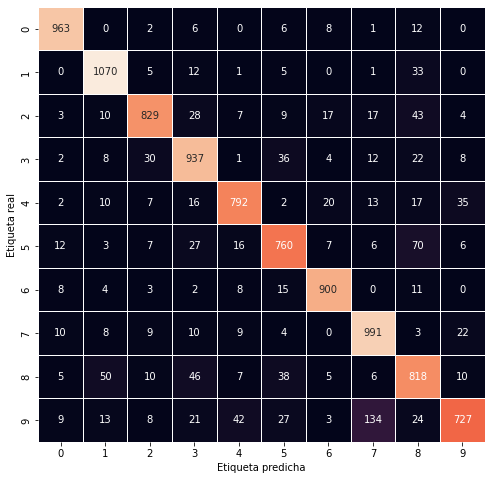

In [93]:
plot_confusion_matrix(y_val, pred_val_perc)

In [94]:
batchsize = int(nr_samples/15) 

In [95]:
from sklearn.neural_network import MLPClassifier

clf_mlp = MLPClassifier(activation = "logistic", hidden_layer_sizes=(200,), random_state=0)
param_grid = { 'batch_size' : [batchsize] , 'max_iter': [600], 'alpha': [1e-4], 
               'solver': ['sgd'], 'learning_rate_init': [0.05,0.06],'tol': [1e-4] }

GridCV_MLP = GridSearchCV(clf_mlp, param_grid, verbose=1, cv=3)
GridCV_MLP.fit(X_train,y_train)
score_grid_MLP = get_best_score(GridCV_MLP)

Fitting 3 folds for each of 2 candidates, totalling 6 fits
0.9601333333333333
{'alpha': 0.0001, 'batch_size': 2000, 'learning_rate_init': 0.06, 'max_iter': 600, 'solver': 'sgd', 'tol': 0.0001}
MLPClassifier(activation='logistic', batch_size=2000, hidden_layer_sizes=(200,),
              learning_rate_init=0.06, max_iter=600, random_state=0,
              solver='sgd')


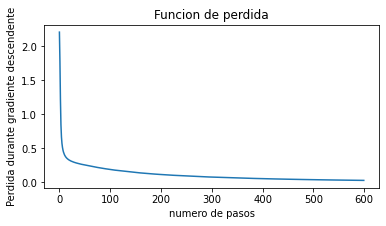

In [96]:
fig, ax = plt.subplots(figsize=(6,3))
ax.plot(GridCV_MLP.best_estimator_.loss_curve_)

plt.xlabel("numero de pasos") 
plt.ylabel("Perdida durante gradiente descendente")
plt.title("Funcion de perdida")
plt.show()

In [97]:
pred_val_mlp = GridCV_MLP.predict(X_val)

In [98]:
acc_mlp = print_validation_report(y_val, pred_val_mlp)

Informe de clasificación
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       998
           1       0.98      0.99      0.98      1127
           2       0.98      0.97      0.98       967
           3       0.97      0.97      0.97      1060
           4       0.97      0.97      0.97       914
           5       0.97      0.96      0.97       914
           6       0.97      0.98      0.98       951
           7       0.97      0.97      0.97      1066
           8       0.97      0.97      0.97       995
           9       0.96      0.95      0.95      1008

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000

Exactitud : 0.9723


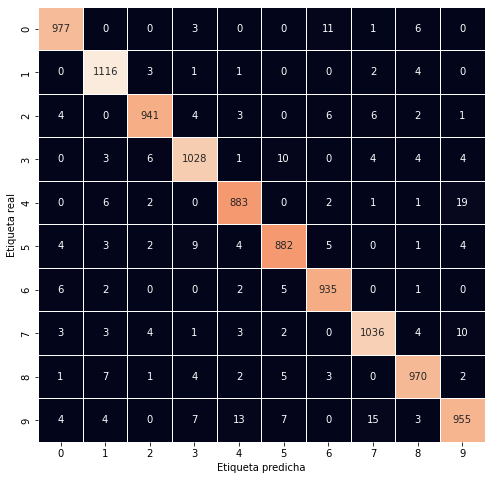

In [99]:
plot_confusion_matrix(y_val, pred_val_mlp)

In [100]:
sample_submission = pd.read_csv('./input/sample_submission.csv')
if mode == "edit" :
    X = X[:nr_samples//2]
    y = y[:nr_samples//2]
    X_test = X_test[:nr_samples//2]
    sample_submission = sample_submission[:nr_samples//2]

In [101]:
print(X.shape)
print(y.shape)
print(X_test.shape)




(42000, 784)
(42000,)
(28000, 784)


In [102]:
print(GridCV_Perceptron.best_params_)
GridCV_Perceptron.best_estimator_.fit(X,y)

{'penalty': 'l1', 'tol': 0.05}


Perceptron(penalty='l1', tol=0.05)

In [103]:
pred_test_perc = GridCV_Perceptron.best_estimator_.predict(X_test)
result_perc = pd.DataFrame({'ImageId':sample_submission.ImageId, 'Label':pred_test_perc})
result_perc.to_csv("subm_perc.csv",index=False)

In [104]:
print(GridCV_MLP.best_params_)
GridCV_MLP.best_estimator_.fit(X,y)

{'alpha': 0.0001, 'batch_size': 2000, 'learning_rate_init': 0.06, 'max_iter': 600, 'solver': 'sgd', 'tol': 0.0001}


MLPClassifier(activation='logistic', batch_size=2000, hidden_layer_sizes=(200,),
              learning_rate_init=0.06, max_iter=600, random_state=0,
              solver='sgd')

In [105]:
pred_test_mlp = GridCV_MLP.best_estimator_.predict(X_test)
result_mlp = pd.DataFrame({'ImageId':sample_submission.ImageId, 'Label':pred_test_mlp})
result_mlp.to_csv("subm_mlp.csv",index=False)

In [106]:
from keras.utils.np_utils import to_categorical
from keras.utils import np_utils
y = to_categorical(y, 10)

In [107]:
predictions = {'PERC': pred_test_perc, 'MLP': pred_test_mlp}
df_predictions = pd.DataFrame(data=predictions) 
df_predictions.corr()

,PERC,MLP
PERC,1.000000,0.852355
MLP,0.852355,1.000000


In [108]:
list_classifiers = ['PERC','MLP']

In [109]:
val_scores = [acc_perc,acc_mlp]

In [110]:
score_perc  = 0.88057
score_mlp   = 0.96985


In [111]:
test_scores = [score_perc,score_mlp]

In [112]:
trace1 = go.Scatter(x = list_classifiers, y = val_scores,
                   name="Validacion", text = list_classifiers)
trace2 = go.Scatter(x = list_classifiers, y = test_scores,
                   name="Prueba", text = list_classifiers)

data = [trace1, trace2]

layout = dict(title = "Validación y puntajes de presentación", 
              xaxis=dict(ticklen=10, zeroline= False),
              yaxis=dict(title = "Precision", side='left', ticklen=10,),
              legend=dict(orientation="v", x=1.05, y=1.0),
              autosize=False, width=750, height=500,
              )

fig = dict(data = data, layout = layout)
iplot(fig)